# Проектный Хакатон MIFIML команды Space Plans

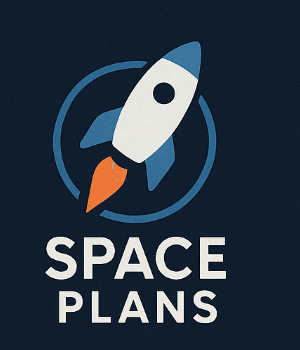

## Структура проекта для Хакатона

### Вводные данные

**Название команды:** Space plans

**Структура команды:**

* **Team leader:** Кловер Натан ( Clover9301@gmail.com )

* **Analytics team:**
  * Воронин Михаил Михайлович ( mixan2912@gmail.com )
  * Прокофьев Михаил Всеволодович ( k0rsair@mail.ru )
  * Жадаев Василий Васильевич ( st1m_97@mail.ru )
  * Колотий Марианна Павловна ( mildburg@rambler.ru )

**Тема проекта:**  Задача №2 — тематическая классификация текстов

**Набор данных:** обработанные нами данные voll_data.csv

___

### Бизнес-постановка задачи

* **Проблема**
  * Современные цифровые каналы ежедневно генерируют большое количество коротких пользовательских сообщений — от комментариев и постов до отзывов и заявок.
  * Эти тексты могут затрагивать разные области: спорт, личную жизнь, политику, рекламу, юмор и социальные сети.

  * В ручном режиме быстро обрабатывать и классифицировать такие сообщения невозможно. Отсутствие автоматизированной системы приводит к:
    * потере времени на разбор и сортировку контента;

    * снижению эффективности реагирования на чувствительные или приоритетные темы (например, политика или негативная реклама);

    * невозможности масштабного анализа пользовательской активности и интересов.

* **Цель**
  * Создать систему, которая определяет вероятность принадлежности текста к одной или нескольким тематикам из заданного списка.
  * Это задача классификации с пересекающимися классами. Один текст может:
    * относиться к нескольким тематикам;
    * не относиться ни к одной из заданных тем.
    * Также необходимо реализовать примитивный веб-интерфейс (UI) для ручного тестирования.


* **Этапы реализации**
  1. **Подготовка и разметка данных**
    * Приведение данных к единому формату
    * Обработка текстов ( удаление лишних запятых, спец.символов, стоп-слов и т.д)
    * Преобразование меток в формат MultiLabelBinarizer
    * Разделение на тренировочную, валидационную и тестовую выборку

  2. **Выбор модели и генерация эмбеддингов**
      * RuBERT
      * TF-IDF
      * FRIDA

  3. **Обучение классификатора**
    * Выбор модели классификатора:
      * Logistic Regression
      * catboost
      * DeepPavlov/rubert-base-cased
    * Подбор гиперпараметров
    * Сохранение выбранной модели и всех преобразователей(tokenizer)

  4. **Оценка качества**
    * Вычисление метрик micro/macro Precision, Recall, F1
    * Построение confusion matrix для каждой темы
    * Анализ ошибок (ложноположительные/ложноотрицательные)

  5. **Разработка веб-интерфейса**
    * Форма для ввода текста и кнопкой для предсказания темы
    * Возможность посмотреть результат в виде класса ( и возможно вероятности )

  6. **Тестирование**
    * Внедрение на этапе разработки тестов assert
    * Проверки на ошибки в работе UI и модели

  7. **Документация и сопровождение**
    * Подготовка README
    * Название, цели и задачи проекта
    * Состав и номер (название) команды
    * Описать этапы и ход работы
    * Раздел про полученные результаты (табличка с метриками(confusion matrix)) и краткие выводы
    * Выделить пояснения в репозитория, что и где находится
    * Приложить инструкцию как её запускать через Докер
    * Приложить интересные графики из EDA и скрины работы вашего приложения


___

## Подготовка данных

### Импорт библиотек

In [1]:
# Установка необходимых библиотек
!pip install -q catboost sentence-transformers wordcloud scikit-multilearn optuna

# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna #left unused for now
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, roc_auc_score, f1_score, precision_recall_curve, average_precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer

from catboost import CatBoostClassifier, Pool
from wordcloud import WordCloud

from sentence_transformers import SentenceTransformer

---
Stop-words
--
---

In [34]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Подготовка списка стоп-слов
russian_stopwords = stopwords.words("russian")
custom_stopwords = ["это", "как", "на", "не", "по", "уже", "что", "ну", "вот", "мы", "ещё", "очень", "спасибо",
                    "всем", "просто", "важно", "сегодня", "вообще", "ссылке", "привет", "писать", "видео", "Тебя", "Им", "вот"
                    "всё", "пока", "люди", "день", "и", "а", "в", "http", "www", "https", "t", "me", "youtube", "com", "be", "youtu", "че", "vk", "ru", "п", "П", "clck", "Мои", "Нам", "Тебе"]
all_stopwords = list(set(russian_stopwords + custom_stopwords))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


---
Загрузка CSV-файла
--
---

In [3]:
# Загрузка нового единого CSV-файла
df = pd.read_csv("voll_data.csv")

In [4]:
print(df.columns)

Index(['full_text', 'predicted_label'], dtype='object')


In [5]:
print(df.head)

<bound method NDFrame.head of                                               full_text predicted_label
0     Вот что меня очень сильно рассмешило в 8-м кла...            юмор
1     Моя любимая история со школы 😂 мы когда когда ...            юмор
2     Не считаю, что Рабьо ляпнул что-то особенное, ...            юмор
3             Девочки Камеди Вумен выгоняют Митю из Шоу            юмор
4     До конца.  #юмор #смешно #тренд суть тренда по...            юмор
...                                                 ...             ...
5674  Хочется к природе. Подальше от искусственного ...    личная_жизнь
5675  Вчера был концерт Москве. Иногда бывает, что с...    личная_жизнь
5676  СО СВИДАНИЯМИ НА НОВЫЕ Полная версия уже на мо...    личная_жизнь
5677  Настоящие герои не носят плащи или маски. прос...    личная_жизнь
5678  ИГРАТЬ СВОЮ ЖИЗНЬ Сатсанг для маленьких от 17....    личная_жизнь

[5679 rows x 2 columns]>


In [6]:
# Стандартная подготовка
X_texts = df["full_text"].fillna("")
y_labels = df["predicted_label"]

# Ограничиваем только допустимыми 6 темами
valid_topics = ["спорт", "юмор", "реклама", "соцсети", "политика", "личная_жизнь"]
df = df[df["predicted_label"].isin(valid_topics)]

In [7]:
# Преобразование мульти-меток в бинарный формат
mlb = MultiLabelBinarizer(classes=valid_topics)
y = mlb.fit_transform([[label] for label in y_labels])

In [8]:
# Убираем классы, где только один класс встречается
valid_columns = np.where(y.sum(axis=0) > 1)[0]
y = y[:, valid_columns]
mlb.classes_ = mlb.classes_[valid_columns]

In [9]:
# Разделение на обучающую и тестовую выборки
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    df["full_text"], y, test_size=0.2, random_state=42
)

--
EDA
--
---

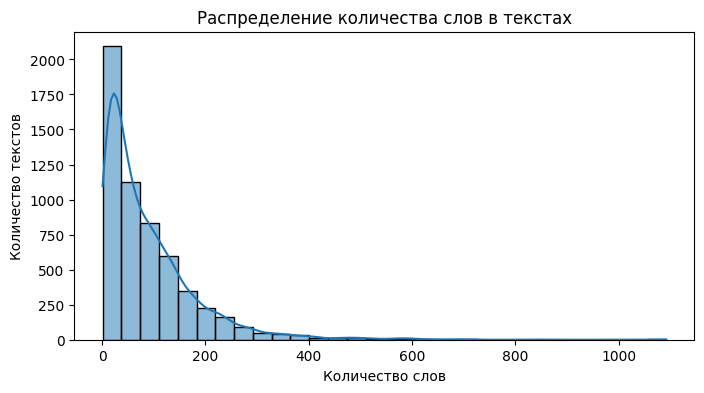

In [10]:
# Распределение количества слов в текстах
df["num_words"] = df["full_text"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8, 4))
sns.histplot(df["num_words"], bins=30, kde=True)
plt.title("Распределение количества слов в текстах")
plt.xlabel("Количество слов")
plt.ylabel("Количество текстов")
plt.show()

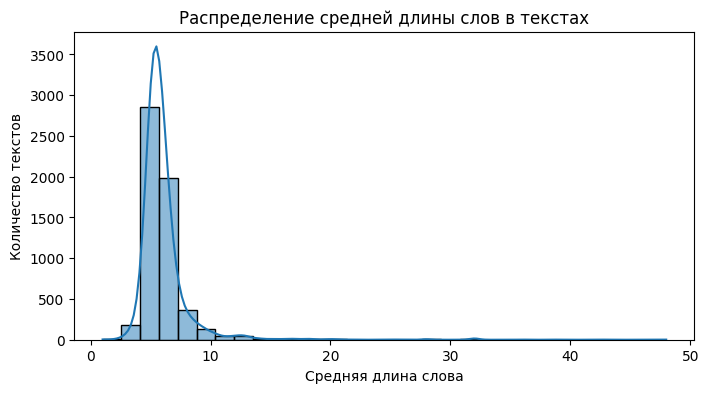

In [11]:
# Средняя длина слова
df["avg_word_length"] = df["full_text"].apply(lambda x: np.mean([len(word) for word in str(x).split()]))

plt.figure(figsize=(8, 4))
sns.histplot(df["avg_word_length"].dropna(), bins=30, kde=True)
plt.title("Распределение средней длины слов в текстах")
plt.xlabel("Средняя длина слова")
plt.ylabel("Количество текстов")
plt.show()

In [12]:
# Подсчёт уникальных слов
all_words = " ".join(df["full_text"]).split()
unique_words = set(all_words)

print(f"Общее количество слов: {len(all_words)}")
print(f"Уникальных слов: {len(unique_words)}")

Общее количество слов: 499849
Уникальных слов: 93308


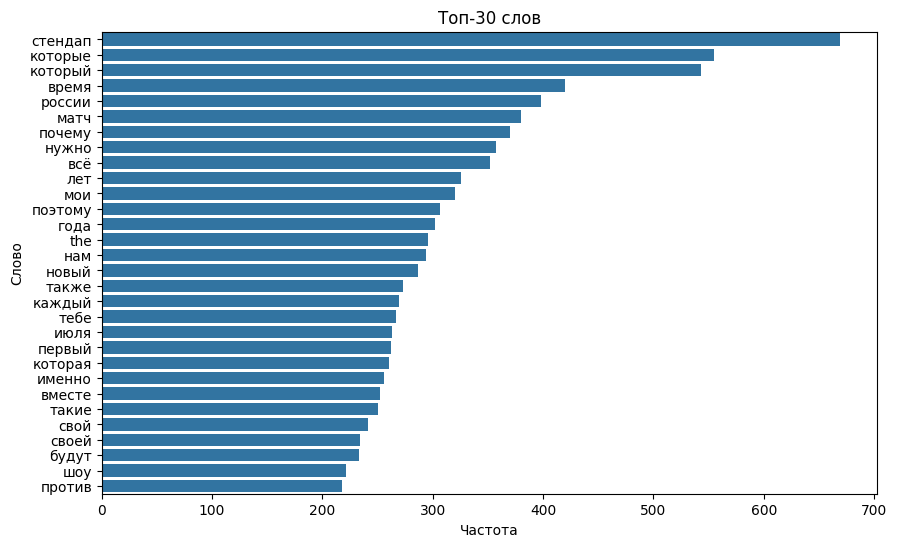

In [35]:
# Убираем стоп-слова + убираем цифры и знаки
filtered_words = []
for word in all_words:
    word = word.lower()
    if word not in all_stopwords and word.isalpha():
        filtered_words.append(word)

# Считаем частоту слов
word_freq = Counter(filtered_words)

# Берём топ-30 слов
top_words = word_freq.most_common(30)

# Строим график
top_words_df = pd.DataFrame(top_words, columns=["Слово", "Частота"])

plt.figure(figsize=(10, 6))
sns.barplot(x="Частота", y="Слово", data=top_words_df)
plt.title("Топ-30 слов")
plt.xlabel("Частота")
plt.ylabel("Слово")
plt.show()

In [36]:
# Для каждой темы считаем топ-10 слов
for topic in df["predicted_label"].unique():
    topic_texts = df[df["predicted_label"] == topic]["full_text"].tolist()

    # Собираем все слова из текстов
    topic_words = []
    for text in topic_texts:
        words = text.split()
        for word in words:
            word = word.lower()
            if word.isalpha() and word not in all_stopwords:
                topic_words.append(word)

    # Считаем частоту слов
    topic_word_freq = Counter(topic_words)
    top_words_topic = topic_word_freq.most_common(10)

    # Выводим топ-10
    print(f"\nТоп-10 слов для темы '{topic}':")
    for word, freq in top_words_topic:
        print(f"{word}: {freq}")


Топ-10 слов для темы 'юмор':
стендап: 486
тебе: 70
натнт: 65
камеди: 61
шапке: 61
такая: 59
тнт: 58
мария: 56
всё: 56
выпуски: 55

Топ-10 слов для темы 'соцсети':
опубликован: 103
комментарий: 102
концерт: 94
выпуск: 77
канал: 72
новый: 68
который: 59
шоу: 56
время: 56
которые: 49

Топ-10 слов для темы 'спорт':
матч: 254
евро: 113
the: 106
футбол: 101
июля: 90
россии: 88
англия: 83
против: 82
время: 78
первый: 77

Топ-10 слов для темы 'политика':
которые: 236
россии: 211
который: 140
нам: 123
должны: 105
россия: 104
лет: 103
время: 102
своих: 100
нашей: 100

Топ-10 слов для темы 'реклама':
который: 129
крови: 109
июля: 101
стать: 99
курса: 93
нужно: 84
десерт: 83
почему: 76
the: 76
to: 73

Топ-10 слов для темы 'личная_жизнь':
мои: 151
карта: 151
тебе: 119
который: 110
жизнь: 101
жизни: 95
ленорман: 94
которые: 94
всё: 91
время: 89


---
TF-IDF
--
---

In [15]:
# Создание TF-IDF эмбеддингов
tfidf = TfidfVectorizer(max_features=5000, stop_words=all_stopwords, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train_texts)
X_test_tfidf = tfidf.transform(X_test_texts)

In [16]:
# Обучение модели логистической регрессии
model_tfidf = MultiOutputClassifier(LogisticRegression(max_iter=1000, class_weight="balanced"))
model_tfidf.fit(X_train_tfidf, y_train)

MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                   max_iter=1000))

In [17]:
# Оценка модели TF-IDF
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)
print("Метрики для TF-IDF + LogisticRegression")
print(classification_report(y_test, y_pred_tfidf, target_names=mlb.classes_))

Метрики для TF-IDF + LogisticRegression
              precision    recall  f1-score   support

       спорт       0.70      0.79      0.74       185
        юмор       0.62      0.70      0.66       210
     реклама       0.74      0.89      0.81       184
     соцсети       0.71      0.66      0.68       192
    политика       0.75      0.93      0.83       175
личная_жизнь       0.61      0.76      0.68       190

   micro avg       0.69      0.79      0.73      1136
   macro avg       0.69      0.79      0.73      1136
weighted avg       0.69      0.79      0.73      1136
 samples avg       0.68      0.79      0.71      1136



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---
Rubert-tiny
--
---

In [18]:
# Быстрая модель (rubert-tiny)
model_tiny = SentenceTransformer("cointegrated/rubert-tiny")
X_train_tiny = model_tiny.encode(X_train_texts.tolist(), show_progress_bar=True)
X_test_tiny = model_tiny.encode(X_test_texts.tolist(), show_progress_bar=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/142 [00:00<?, ?it/s]

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

In [19]:
# Обучение CatBoost на rubert-tiny эмбеддингах
train_pool_tiny = Pool(X_train_tiny, label=y_train)
test_pool_tiny = Pool(X_test_tiny, label=y_test)

model_tiny_cb = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    random_strength=1,
    bagging_temperature=1,
    loss_function='MultiLogloss',
    random_seed=42,
    early_stopping_rounds=20,
    verbose=100
)

model_tiny_cb.fit(train_pool_tiny, eval_set=test_pool_tiny)

y_pred_tiny = model_tiny_cb.predict(test_pool_tiny).astype(int)

print("Метрики для rubert-tiny + CatBoost")
print(classification_report(y_test, y_pred_tiny, target_names=mlb.classes_, zero_division=0))

0:	learn: 0.6613458	test: 0.6622786	best: 0.6622786 (0)	total: 622ms	remaining: 3m 6s
100:	learn: 0.2427515	test: 0.3019208	best: 0.3019208 (100)	total: 44.7s	remaining: 1m 28s
200:	learn: 0.1717056	test: 0.2699249	best: 0.2699249 (200)	total: 1m 28s	remaining: 43.5s
299:	learn: 0.1236106	test: 0.2537984	best: 0.2537984 (299)	total: 2m 28s	remaining: 0us

bestTest = 0.2537983563
bestIteration = 299

Метрики для rubert-tiny + CatBoost
              precision    recall  f1-score   support

       спорт       0.80      0.39      0.52       185
        юмор       0.77      0.39      0.51       210
     реклама       0.94      0.41      0.57       184
     соцсети       0.81      0.46      0.59       192
    политика       0.87      0.62      0.72       175
личная_жизнь       0.88      0.38      0.53       190

   micro avg       0.84      0.44      0.58      1136
   macro avg       0.84      0.44      0.57      1136
weighted avg       0.84      0.44      0.57      1136
 samples avg       0

---
FRIDA -tiny
--
---

In [20]:
# Генерация эмбеддингов с использованием SentenceTransformer (FRIDA-tiny)
frida_model = SentenceTransformer("cointegrated/rubert-tiny2")
X_train_frida = frida_model.encode(X_train_texts.tolist(), show_progress_bar=True)
X_test_frida = frida_model.encode(X_test_texts.tolist(), show_progress_bar=True)

Batches:   0%|          | 0/142 [00:00<?, ?it/s]

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

In [21]:
# Обучение модели CatBoost на эмбеддингах FRIDA
train_pool = Pool(X_train_frida, label=y_train)
test_pool = Pool(X_test_frida, label=y_test)

In [22]:
#Обучение CatBoost на лучших параметрах
model_frida_cb = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    random_strength=1,
    bagging_temperature=1,
    loss_function='MultiLogloss',
    random_seed=42,
    early_stopping_rounds=20,
    verbose=100
)

model_frida_cb.fit(train_pool, eval_set=test_pool)


0:	learn: 0.6623796	test: 0.6629923	best: 0.6629923 (0)	total: 900ms	remaining: 4m 29s
100:	learn: 0.2298859	test: 0.2892744	best: 0.2892744 (100)	total: 54.7s	remaining: 1m 47s
200:	learn: 0.1578541	test: 0.2520550	best: 0.2520550 (200)	total: 1m 38s	remaining: 48.4s
299:	learn: 0.1120874	test: 0.2330856	best: 0.2330856 (299)	total: 2m 24s	remaining: 0us

bestTest = 0.2330856088
bestIteration = 299



In [23]:
# Предсказания модели CatBoost
y_pred_frida = model_frida_cb.predict(test_pool)
y_pred_frida = y_pred_frida.astype(int)

In [24]:
# Метрики CatBoost
print("Метрики для FRIDA-tiny + CatBoost")
print(classification_report(y_test, y_pred_frida, target_names=mlb.classes_))


Метрики для FRIDA-tiny + CatBoost
              precision    recall  f1-score   support

       спорт       0.82      0.58      0.68       185
        юмор       0.78      0.40      0.53       210
     реклама       0.95      0.47      0.63       184
     соцсети       0.87      0.45      0.59       192
    политика       0.89      0.69      0.78       175
личная_жизнь       0.92      0.42      0.57       190

   micro avg       0.87      0.50      0.63      1136
   macro avg       0.87      0.50      0.63      1136
weighted avg       0.87      0.50      0.63      1136
 samples avg       0.49      0.50      0.49      1136



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
# Кластеризация текстов с помощью эмбеддингов
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(X_train_frida)


In [26]:
# Добавляем кластеры в датасет
df_clusters = pd.DataFrame(X_train_frida)
df_clusters["cluster"] = clusters


In [27]:
# Оценка ROC-AUC для моделей
y_train_pred_probs = model_frida_cb.predict_proba(train_pool)
y_test_pred_probs = model_frida_cb.predict_proba(test_pool)

roc_auc_train = roc_auc_score(y_train, y_train_pred_probs, average="macro")
roc_auc_test = roc_auc_score(y_test, y_test_pred_probs, average="macro")

print(f"ROC-AUC Train: {roc_auc_train:.4f}")
print(f"ROC-AUC Test: {roc_auc_test:.4f}")


ROC-AUC Train: 0.9982
ROC-AUC Test: 0.9368



Итоговое сравнение моделей по Macro-F1:
                             Macro-F1
TF-IDF + LogisticRegression  0.733769
FRIDA-tiny2 + CatBoost       0.629900
rubert-tiny + CatBoost       0.574406


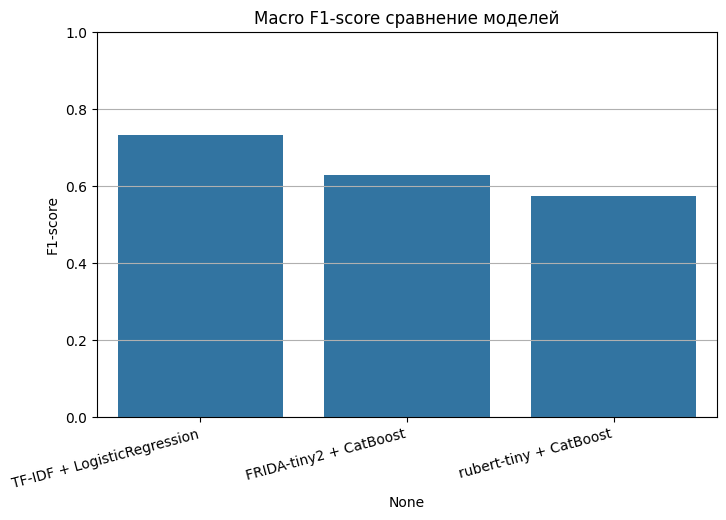

In [28]:
# Расчёт macro-F1 для всех трёх моделей
macro_scores = {
    "TF-IDF + LogisticRegression": f1_score(y_test, y_pred_tfidf, average="macro"),
    "FRIDA-tiny2 + CatBoost": f1_score(y_test, y_pred_frida, average="macro"),
    "rubert-tiny + CatBoost": f1_score(y_test, y_pred_tiny, average="macro")
}

# Вывод красивой таблицы
macro_scores_df = pd.DataFrame.from_dict(macro_scores, orient="index", columns=["Macro-F1"])
macro_scores_df = macro_scores_df.sort_values("Macro-F1", ascending=False)

print("\nИтоговое сравнение моделей по Macro-F1:")
print(macro_scores_df)

# Визуализация
plt.figure(figsize=(8, 5))
sns.barplot(x=macro_scores_df.index, y=macro_scores_df["Macro-F1"])
plt.xticks(rotation=15, ha="right")
plt.ylim(0, 1)
plt.title("Macro F1-score сравнение моделей")
plt.ylabel("F1-score")
plt.grid(axis="y")
plt.show()

---
Визуализация
--
---

<ipython-input-29-69526ed5b3e6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="cluster", data=df_clusters, palette="Set2")


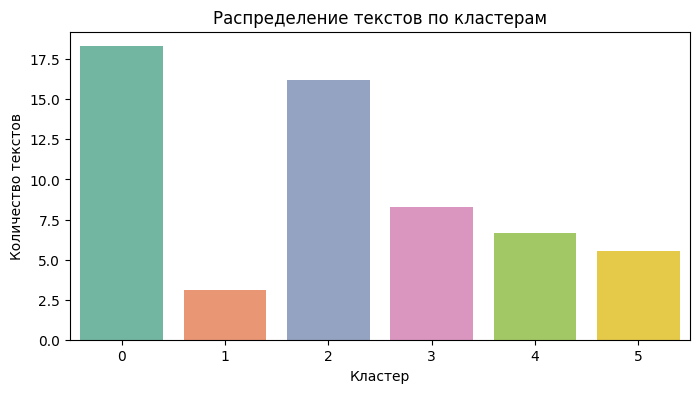

In [29]:
# Визуализация распределения по кластерам
plt.figure(figsize=(8, 4))
sns.countplot(x="cluster", data=df_clusters, palette="Set2")
plt.title("Распределение текстов по кластерам")
plt.xlabel("Кластер")
plt.ylabel("Количество текстов")
plt.show()


In [38]:
cluster_to_topic = {
    0: "спорт",
    1: "юмор",
    2: "реклама",
    3: "соцсети",
    4: "политика",
    5: "личная_жизнь"
}


In [39]:
print("\nПримеры текстов для каждого кластера:")
# После создания эмбеддингов
kmeans = KMeans(n_clusters=6, random_state=42)
cluster_labels = kmeans.fit_predict(X_train_tiny)

clustered_texts = pd.DataFrame({
    "text": X_train_texts,   # важно использовать правильные тексты
    "cluster": cluster_labels
})

for cluster_num in sorted(clustered_texts["cluster"].unique()):
    cluster_name = cluster_to_topic.get(cluster_num, f"Кластер {cluster_num}")
    sample_texts = clustered_texts[clustered_texts["cluster"] == cluster_num]["text"].sample(3, random_state=42)

    print(f"\nТема '{cluster_name}' (кластер {cluster_num}):")
    for idx, text in enumerate(sample_texts, 1):
        print(f"{idx}. {text[:300]}")  # Ограничение 300 символов для удобства чтения


Примеры текстов для каждого кластера:

Тема 'спорт' (кластер 0):
1. 1989-й. Фарцовщик Рома Жуков, феноменальный успех "Ласкового мая", волшебный Женя Белоусов, последняя перепись советского населения и всяческого добра ещё навалом.   https://vk.com/wall-39661395_28314  Я календарь переверну в 1989!
2. ebanulisnews https://t.me/ebanulisnews/40352    В Польше кошка открыла кран с водой, пока хозяев не было дома, и затопила квартиру. После чего последовал поляк moment, перевод которого не требуется  Я пердоле Чо курво ебана? Я пердоле Че с прук не прешло? Я пердоле Як я там це зараз? Я пердоле Щмецю
3. финансовый продукт. Да, я тоже залететь на волну и сделал крипто кликер. Отправляй ссылку друзьям: Давайте рубить капусту 🤑🤑🤑🤑🤑 sobolev бот отмена илья (сео) в час +1,11 к / 11 » se комбо 01: 18 13 :18 ежедневный 18 21 711 / 2000 boost mine airdrop friends

Тема 'юмор' (кластер 1):
1. Отрывки для ваших репостов в соцсетях 👇👇👇👇👇👇👇👇 да, я в тольятти работал на автовазе я в тольятти работал н

In [40]:
# Функция построения облака слов для кластеров
def plot_wordclouds_by_cluster(df, embeddings, cluster_labels, n_clusters=6, cluster_to_topic=None):
    for cluster_num in range(n_clusters):
        indices = np.where(cluster_labels == cluster_num)[0]
        cluster_texts = df.iloc[indices]  #использовать переданный df

        combined_text = " ".join(cluster_texts)

        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color="white",
            stopwords=all_stopwords,
            max_words=100
        ).generate(combined_text)

        plt.figure(figsize=(8, 4))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")

        # Используем либо имя темы из словаря, либо номер кластера
        if cluster_to_topic is not None:
            cluster_name = cluster_to_topic.get(cluster_num, f"Кластер {cluster_num}")
        else:
            cluster_name = f"Кластер {cluster_num}"

        plt.title(f"Облако слов для темы: {cluster_name}")
        plt.show()


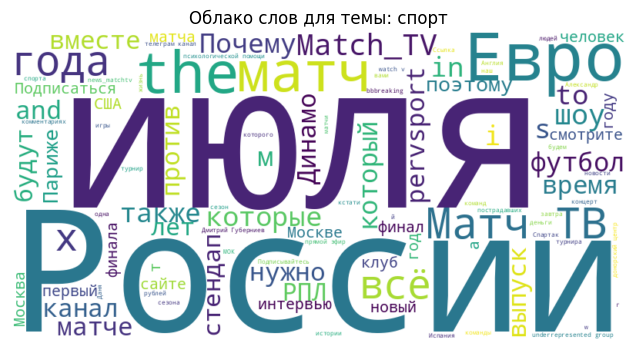

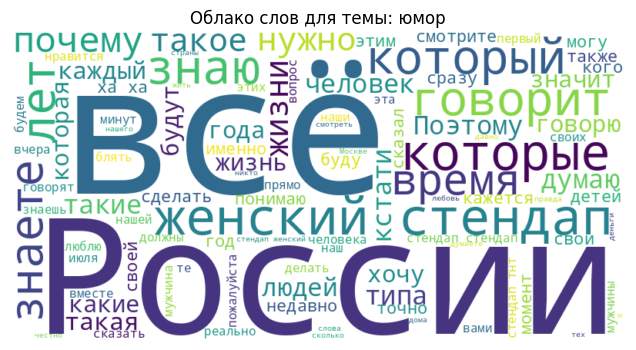

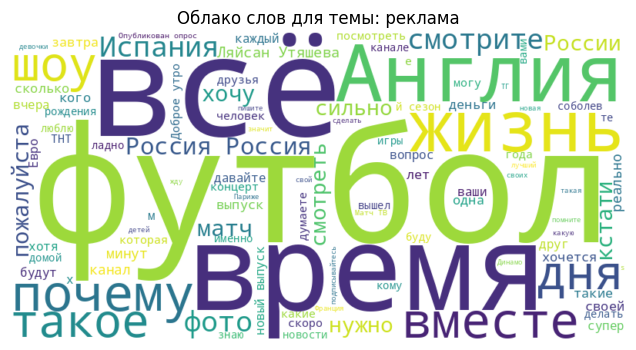

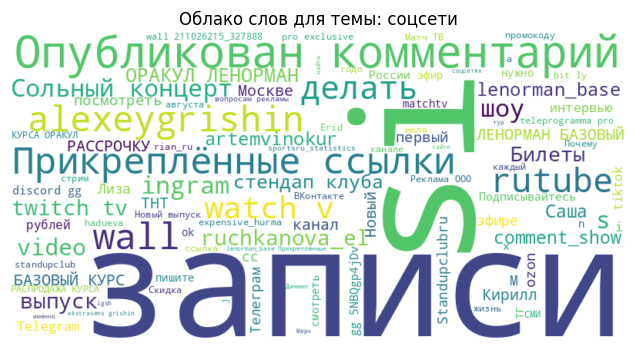

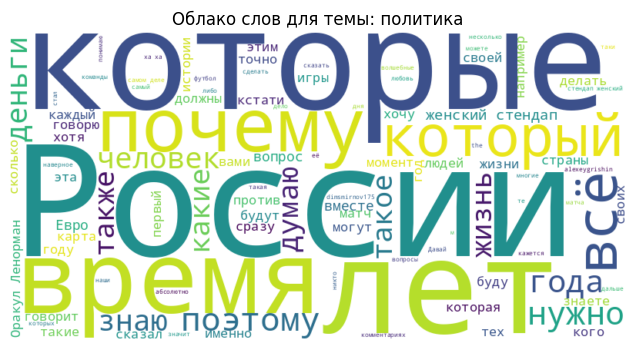

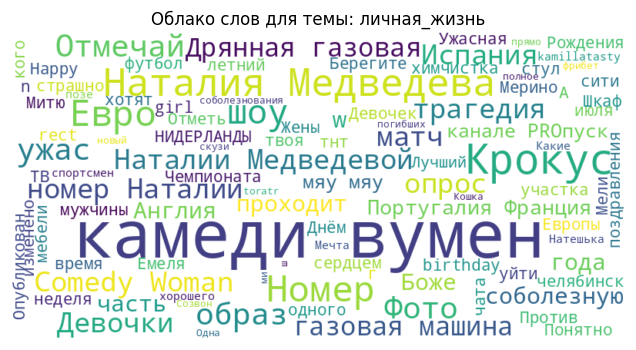

In [41]:
# Построение облаков слов для кластеров
plot_wordclouds_by_cluster(X_train_texts, X_train_tiny, cluster_labels, n_clusters=6, cluster_to_topic=cluster_to_topic)


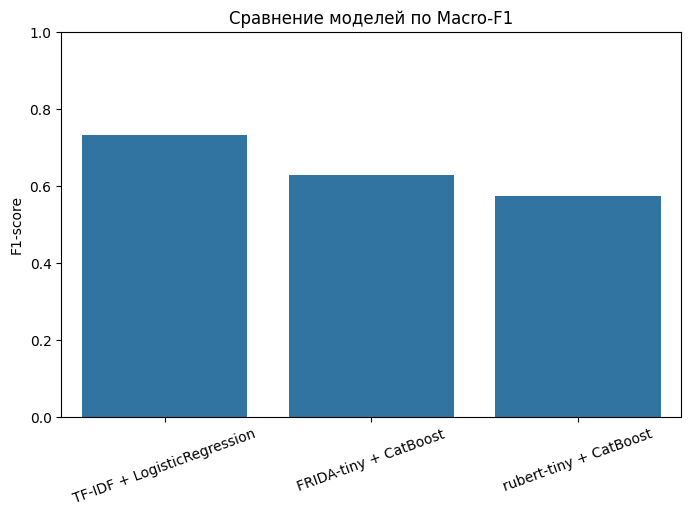

TF-IDF + LogisticRegression: 0.7338
FRIDA-tiny + CatBoost: 0.6299
rubert-tiny + CatBoost: 0.5744


In [42]:
# Сравнение Macro-F1 для разных моделей
macro_scores = {
    "TF-IDF + LogisticRegression": f1_score(y_test, y_pred_tfidf, average="macro"),
    "FRIDA-tiny + CatBoost": f1_score(y_test, y_pred_frida, average="macro"),
    "rubert-tiny + CatBoost": f1_score(y_test, y_pred_tiny, average="macro")
}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(macro_scores.keys()), y=list(macro_scores.values()))
plt.title("Сравнение моделей по Macro-F1")
plt.ylabel("F1-score")
plt.ylim(0, 1)
plt.xticks(rotation=20)
plt.show()

for model_name, score in macro_scores.items():
    print(f"{model_name}: {score:.4f}")

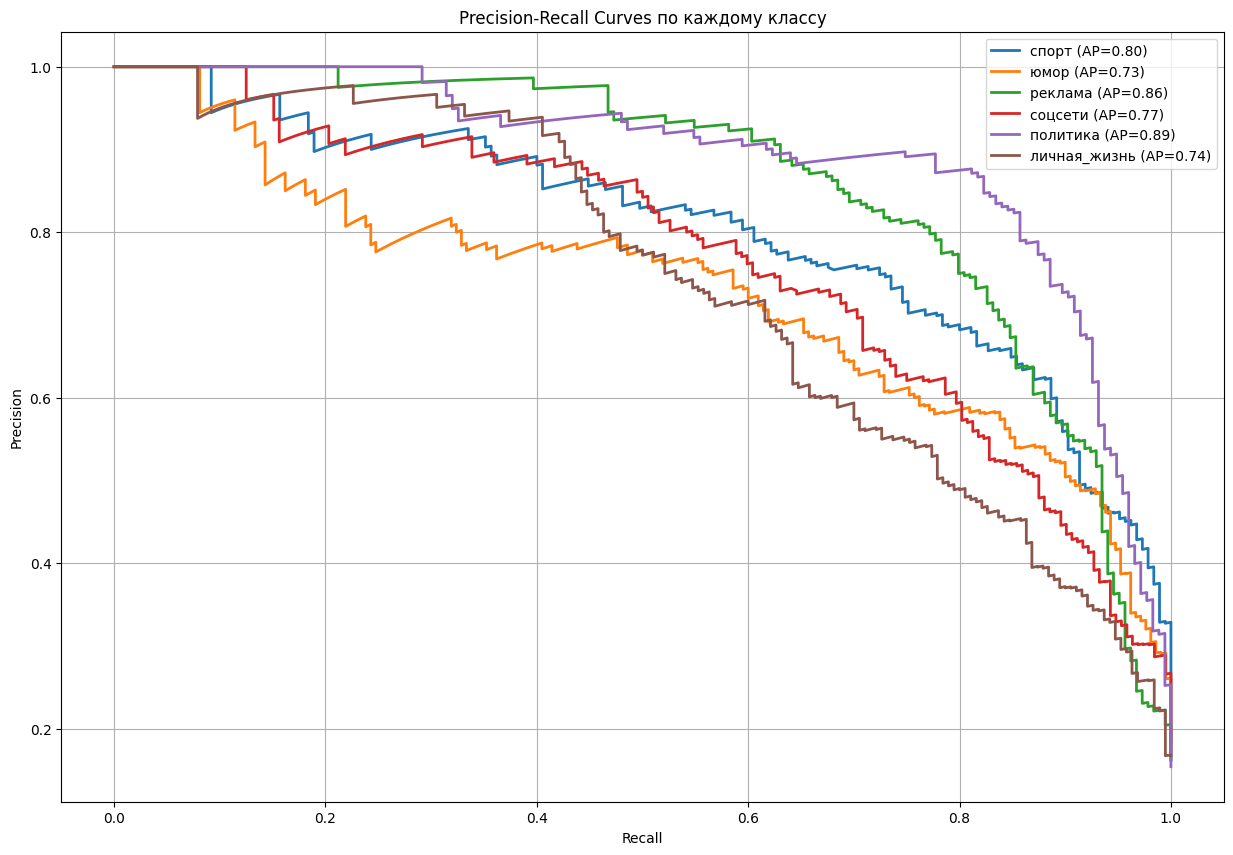

In [43]:
# Построение Precision-Recall кривых
def plot_precision_recall(y_true, y_probs, class_names):
    n_classes = y_true.shape[1]
    plt.figure(figsize=(15, 10))

    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
        ap = average_precision_score(y_true[:, i], y_probs[:, i])
        plt.plot(recall, precision, lw=2, label=f'{class_names[i]} (AP={ap:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves по каждому классу')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Строим PR-кривые для CatBoost модели
plot_precision_recall(y_test, y_test_pred_probs, mlb.classes_)

---
Финальный мастер-блок (Все вместе)
--
---